In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model
from lmfit import Parameters
from functions import tof2eBE, jacobian, calibrate

Load and plot calibration dataset to inspect (example uses a static run with N2 in the chamber)

Text(0, 0.5, 'Counts')

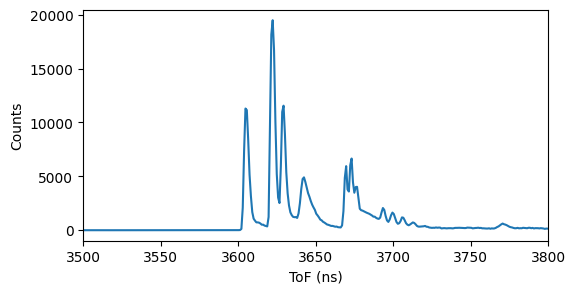

In [2]:
#load and plot calib file
calib_path = "processed_data/run_277_processed.txt"
calib_data = np.genfromtxt(calib_path)

tof = calib_data[0,1:]
delay = calib_data[1:,0]
z = calib_data[1:,1:]

spec = np.sum(z, axis=0)

fig,ax=plt.subplots(figsize = (6,3))
ax.plot(tof, spec)
ax.set_xlim(3500,3800)
ax.set_xlabel("ToF (ns)")
ax.set_ylabel("Counts")


Perform tof2eBE calibration. 
Specify initial guesses for t0, hv, s and E0 and give tof/eV pairs from literature spectra.
This cell then fits the data to the tof2eBE function provided in functions.py


name,value,standard error,relative error,initial value,min,max,vary
hv,22.3600484,0.11786904,(0.53%),21.7,19.7000000,23.7000000,True
s,0.37368776,0.00235695,(0.63%),0.35,0.30000000,0.40000000,True
t0,3428.50000,0.00000000,(0.00%),3428.5,3378.50000,3478.50000,False
E0,0.00000000,0.00000000,,0,-0.20000000,0.20000000,False


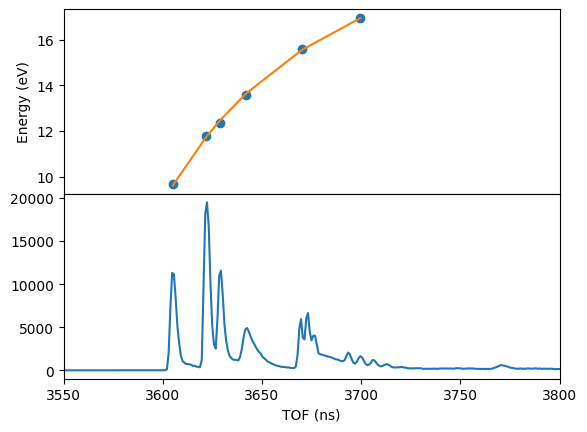

In [3]:
# initial guesses
t0 = 3428.5 #from spike in spectra
hv = 21.7 #guess
s = 0.35 #from Kaesdorf specs
E0 = 0 #guess

# calib pairs taken from sample literature references and nitrogen peaks
tof_cal = np.array([3605,3622,3629,3642,3670,3699.6])
energy_cal = np.array([9.666,11.8,12.375,13.592,15.6,16.98])

model = Model(tof2eBE)
params = Parameters()

params.add('hv', value = hv,min = hv-2, max = hv+2) #in eV
params.add('s', value = s,min = s-0.05, max = s+0.05,vary = True)    #in m
params.add('t0', value = t0,min = t0 - 50, max = t0+50,vary = False)  # in ns
params.add('E0',value = E0,min = E0-0.2, max = E0+0.2,vary = False)  #in V

result = model.fit(energy_cal, params, x=tof_cal)

fig,axs = plt.subplots(2,sharex = True)
axs[0].plot(tof_cal,energy_cal,'o')
axs[0].plot(tof_cal,result.best_fit)
axs[1].plot(tof,spec)
plt.xlim(3550,3800)
plt.subplots_adjust(hspace = 0)
axs[1].set_xlabel('TOF (ns)')
axs[0].set_ylabel('Energy (eV)')

#save params
params = []
for param_name in result.params:
    params.append(result.params[param_name].value)

result.params

Save the calibration parameters to the calibration folder. When this is done, the saved parameters can be used with calib.py to calibrate the whole dataset and save. 

In [4]:
np.savetxt('calibrations/calib_params.txt',params, header = 'hv, s, t0, E0')
